<a href="https://colab.research.google.com/github/alisharifi2000/ACO_TSP/blob/main/ACO_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [306]:
!pip install opencage
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp36-cp36m-linux_x86_64.whl size=121757233 sha256=b0638f82a567e3faf7be096b9cb886087d07bab7b2eeaeeacd8b2a2ddea53130
  Stored in directory: /tmp/pip-ephem-wheel-cache-8prfv_0d/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [307]:
import numpy as np
import pandas as pd
from geopy import distance
from opencage.geocoder import OpenCageGeocode
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import random
from itertools import chain
import time

In [308]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

In [309]:
def get_location(city,country):
    key = ''
    geocoder = OpenCageGeocode(key)
    query = city+' , '+country  
    results = geocoder.geocode(query)
    lat = results[0]['geometry']['lat']
    lng = results[0]['geometry']['lng']
    
    return [lat,lng]

In [310]:
def get_city_country(cities):
  city = [c.split(',')[0] for c in cities.split('\n')]
  print(city)
  country = [c.split(',')[1] for c in cities.split('\n')]
  print(country)

  return [city,country]

In [311]:
def make_dataset(city,country):
  # make dataframe 
  dict = {'City':city,'Country':country}
  dataset = pd.DataFrame(dict)
  dataset['lat'] = 0
  dataset['lng'] = 0
  dataset.index = dataset['City']

  return dataset

In [312]:
def fill_lat_lng(dataset):
  for c in list(dataset.index):
      city_name = dataset.loc[c,'City']
      country_name = dataset.loc[c,'Country']
      [lat,lng] = get_location(city_name,country_name)
      dataset.loc[c,'lat'] = lat
      dataset.loc[c,'lng'] = lng
    
  return dataset

In [313]:
def draw_cities_in_map(dataset):
  fig = plt.figure(figsize=(15, 10), edgecolor='w')
  m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
  m.scatter(dataset['lng'], dataset['lat'], latlon=True,
          c = 'black', s = 5)
  draw_map(m)

In [314]:
def make_dict_from_dataset(dataset):
    dict = {}
    for c in dataset['City'].values:
        name = dataset.loc[c,'City']
        lat = dataset.loc[c,'lat']
        lng = dataset.loc[c,'lng']

        dict[name] = [lat,lng]
    
    return dict

In [315]:
def createDistanceMatrix(cities):
    numcities = len(cities.keys())
    distmatrix = pd.DataFrame(columns=list(
        cities.keys()), index=list(cities.keys()))
    listcities = list(cities.keys())
    for i in range(numcities):
        for j in range(numcities):
            if i == j:
                distmatrix.iloc[i, j] = np.inf
            else:
                orign = tuple(cities[listcities[i]])
                dist = tuple(cities[listcities[j]])
                d = int(distance.distance(orign,dist).km)
                distmatrix.iloc[i, j] = d
                distmatrix.iloc[j, i] = distmatrix.iloc[i, j]
    
    return distmatrix

In [316]:
def createCompleteGraph(cities):
    numcities = len(cities.keys())
    edges = {}
    weight = 1/numcities
    listcities = list(cities.keys())
    for i in range(numcities):
        edge = {}
        for j in range(numcities):
            if j != i:
                edge[listcities[j]] = weight
        edges[listcities[i]] = edge
    
    return edges

In [317]:
class World:
    def __init__(self, cities):
        self.distmatrix = createDistanceMatrix(cities )
        self.edges = createCompleteGraph(cities)
        self.cities = cities
        self.numcities = numcities

In [318]:
class AntColony:
    def __init__(self, n_ants = 10, n_iterations = 50, Q = 10, decay=0.6, alpha=1, beta=1):
        '''
        n_ants
        n_iterations
        Q  pheromone intensity
        decay
        alpha
        beta
        '''
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.glbpath = {}
        self.history = {}

    def createPherorMatrix(self, world):
        self.pheromone = pd.DataFrame(columns=list(world.cities.keys()),
                                      index=list(world.cities.keys()))
        for i in range(world.numcities):
            for j in range(world.numcities):
                self.pheromone.iloc[i, j] = 1/len(world.cities.keys())
                self.pheromone.iloc[j, i] = self.pheromone.iloc[i, j]

    def createColony(self):
        self.colony = {}
        for i in range(self.n_ants):
            self.colony[i] = {"path": [], "dist": 0}

    def initializeColony(self, world):
        if self.n_ants == len(world.cities.keys()):
            for i, city in zip(range(self.n_ants), world.cities.keys()):
                self.colony[i]["path"] = [city]
        else:
            for i in range(self.n_ants):
                self.colony[i]["path"] = [list(world.cities.keys())[
                    np.random.randint(world.numcities)]]

    def calculateProba(self, world):
        proba = pd.DataFrame(columns=list(world.cities.keys()), index=list(world.cities.keys()))
        for i in range(world.numcities):
            for j in range(world.numcities):
                proba.iloc[i, j] = ((self.pheromone.iloc[i, j])**self.alpha) * \
                    ((world.distmatrix.iloc[i, j])**-self.beta)
                proba.iloc[j, i] = proba.iloc[i, j]
        return proba

    def calculateProba_ant(self, world, unvisitedcity, currentcity, proba):
        sigma = 0
        for h in unvisitedcity:
            sigma += ((self.pheromone.loc[currentcity, h])**self.alpha) * \
                ((world.distmatrix.loc[currentcity, h])**-self.beta)
        probaant = proba.loc[currentcity, :]/sigma
        return pd.to_numeric(probaant)

    def findBestPath(self):
        bpath = []
        bestdist = np.inf
        idxbest = 0
        for i in range(self.n_ants):
            if self.colony[i]["dist"] < bestdist:
                bestdist = self.colony[i]["dist"]
                bpath = self.colony[i]["path"]
                idxbest = i
        bpath = {"path": bpath, "dist": bestdist, "ant": idxbest}
        return bpath

    def updatePherorMatrix(self, world):
        depositpher = 0
        for i in range(self.n_ants):
            for j in range(len(self.colony[i]["path"])-1):
                src, dest = self.colony[i]["path"][j], self.colony[i]["path"][j+1]
                self.pheromone.loc[src, dest] += self.Q/self.colony[i]["dist"]
            depositpher += self.Q/self.colony[i]["dist"]
        for i in range(world.numcities):
            for j in range(world.numcities):
                self.pheromone.iloc[i, j] = (1-self.decay)*self.pheromone.iloc[i, j]*depositpher
                self.pheromone.iloc[j, i] = self.pheromone.iloc[i, j]

    def calculateDist_ant(self, world, ant):
        dist = 0
        for i in range(len(self.colony[ant]["path"])-1):
            dist += world.distmatrix.loc[self.colony[ant]["path"][i], self.colony[ant]["path"][i+1]]
        return dist
    def run(self, world , verbose = 0):
        path, dist = "path", "dist"
        history_iter = []
        self.createColony()
        self.createPherorMatrix(world)
        start = time.time()
        for i in range(self.n_iterations):
            proba = self.calculateProba(world)
            self.initializeColony(world)
            for ant in range(self.n_ants):
                # for each ant find a path
                unvisitedcity = list(world.cities.keys())
                currentcity = self.colony[ant]["path"][0]
                unvisitedcity.remove(currentcity)
                for j in range(1, world.numcities):
                    if len(unvisitedcity) > 1:
                        probaant = self.calculateProba_ant(world, unvisitedcity, currentcity, proba)
                        currentcity = probaant.loc[unvisitedcity].idxmax()
                        unvisitedcity.remove(currentcity)
                        self.colony[ant]["path"].append(currentcity)
                    else:
                        self.colony[ant]["path"].append(unvisitedcity[0])
                self.colony[ant]["dist"] = self.calculateDist_ant(world, ant)
                # print("Ant",self.colony[ant])

            self.updatePherorMatrix(world)
            bpath = self.findBestPath()
            if i == 0:
                self.gbpath = bpath
            else:
                if bpath["dist"] < self.gbpath["dist"]:
                    self.gbpath = bpath
            # print(f"Iteration {i+1}: best path: {bpath[path]}, distance: {bpath[dist]}")
            history_iter.append(bpath[dist])
        run_time = time.time()-start
        min_cost = calculate_min_cost(world , self.gbpath[path])
        self.history = {'cost':min_cost,'path':self.gbpath[path],'history':history_iter,'time':run_time}

In [319]:
def calculate_min_cost(world , path):
    mincost = 0
    for i in range(len(path)-1):
        city1 = path[i]
        city2 = path[i+1]
        mincost = mincost + world.distmatrix.loc[city1, city2]

    return mincost

In [320]:
def plot_aco_convergence(costs):
    x = range(len(costs))
    plt.figure(figsize=(10, 5), edgecolor='w')
    plt.title("ACO Convergence")
    plt.xlabel('Iteration')
    plt.ylabel('cost (KM)')
    plt.text(x[len(x) // 2], costs[0], 'min cost: {} KM'.format(costs[-1]), ha='center', va='center')
    plt.plot(x, costs, '-')

In [321]:
def plot_route(world,path):
    plt.figure(figsize=(15, 10), edgecolor='w')
    plt.title("Best Route (start point is blue )")
    m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
    
    lat = []
    lon = []

    for i in range(len(path)):
      lat.append(world.cities[path[i]][0])
      lon.append(world.cities[path[i]][1])

    x, y = m(lon, lat)

    
    m.plot(x, y, '--', markersize=4, linewidth=1 , c = 'red')

    m.scatter(x, y, latlon=True,
          c = 'black', s = 8)
    
    m.scatter(lon[0], lat[0], latlon=True,
          c = 'blue', s = 15 , marker = 'x')
    
    draw_map(m)

In [322]:
def best_path(path,min_cost,run_time):
    print('ACO completed')
    print(f'Minimum travelling cost {min_cost} KM')
    print(f"Evolution in {run_time} s")
    print('-----------------')
    print('Best Path : ')
    print('-----------------')
    for i in range(len(path)):
        print(f"{i+1}. {path[i]}")

# 10 Cities

In [323]:
# 10 cities
cities = """New York,USA
Los Angeles,USA
Chicago,USA
London,UK
Paris,France
Tehran,Iran
Istanbul,Turkey
San Francisco,USA
Washington DC,USA
Boston,USA"""

In [324]:
result = get_city_country(cities)
dataset = make_dataset(result[0],result[1])
dataset = fill_lat_lng(dataset)
city_dict = make_dict_from_dataset(dataset)
dataset.head()

['New York', 'Los Angeles', 'Chicago', 'London', 'Paris', 'Tehran', 'Istanbul', 'San Francisco', 'Washington DC', 'Boston']
['USA', 'USA', 'USA', 'UK', 'France', 'Iran', 'Turkey', 'USA', 'USA', 'USA']


,City,Country,lat,lng
City,,,,
New York,New York,USA,40.712728,-74.006015
Los Angeles,Los Angeles,USA,34.053691,-118.242766
Chicago,Chicago,USA,41.875562,-87.624421
London,London,UK,51.507322,-0.127647
Paris,Paris,France,48.856697,2.351462


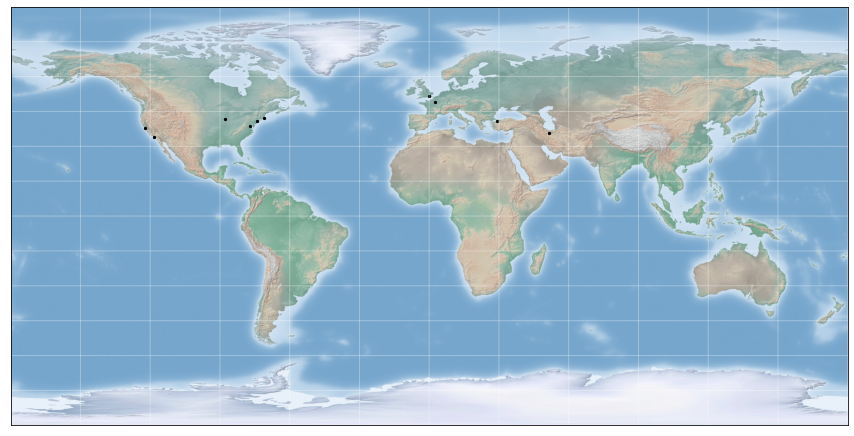

In [325]:
draw_cities_in_map(dataset)

## defult parameters

ACO completed
Minimum travelling cost 14884.691180326305 KM
Evolution in 8.750571489334106 s
-----------------
Best Path : 
-----------------
1. Tehran
2. Istanbul
3. Paris
4. London
5. Boston
6. New York
7. Washington DC
8. Chicago
9. Los Angeles
10. San Francisco


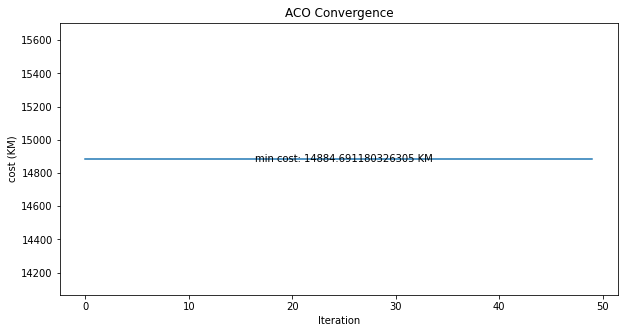

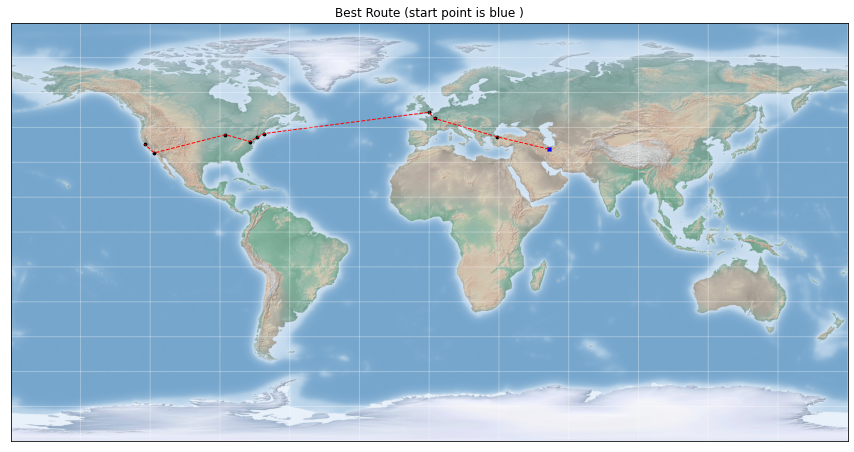

In [326]:
 '''
n_ants = 10
n_iterations = 50
Q = 10
decay = 0.6
alpha = 1
beta = 1
'''
world = World(city_dict)
problem = AntColony()
problem.run(world)

best_path(best_history['path'],best_history['cost'],best_history['time'])
plot_aco_convergence(best_history['history'])
plot_route(world,best_history['path'])